In [1]:
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

from markov_regime import *

In [2]:
end = dt.datetime.today()
start = dt.datetime(end.year - 10, end.month, end.day)

In [3]:
ticker = "^GSPC"
price_type = "Adj Close"
frequency = "weekly"

In [4]:
#getting prices
df = Prices(start, end, ticker, price_type, frequency).getPrices()
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2011-05-30,1300.160034
2011-06-06,1270.979980
2011-06-13,1271.500000
2011-06-20,1268.449951
2011-06-27,1339.670044


smoothed_probability


/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


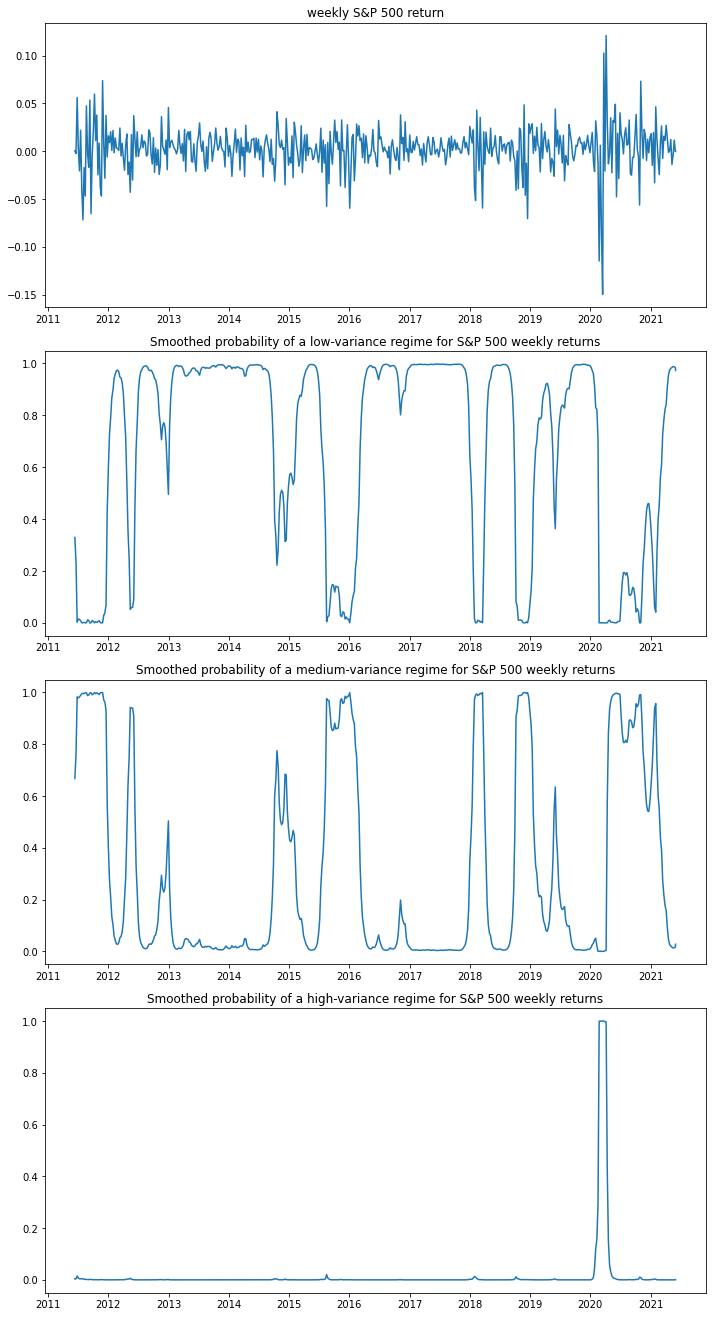

In [5]:
#lets look at the regimes plots
plot = TimeSeries(df, ticker, frequency, price_type).plot_smoothed_probability()

In [6]:
#the goal is to invert the low and medium variances and then find the covaraince for them to create indicator functions
regimes = TimeSeries(df, ticker, frequency, price_type).get_regime_data()
regimes.head()

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,low_variance,medium_variance,high_variance
Date,,,
2011-06-13,0.328786,0.667559,0.003655
2011-06-20,0.234574,0.761374,0.004052
2011-06-27,0.002712,0.982479,0.014809
2011-07-04,0.015028,0.978358,0.006614
2011-07-11,0.013043,0.982640,0.004317


In [7]:
#now let's isolate the two regimes
low_med = regimes[['low_variance', 'medium_variance']]
low_med.head()

,low_variance,medium_variance
Date,,
2011-06-13,0.328786,0.667559
2011-06-20,0.234574,0.761374
2011-06-27,0.002712,0.982479
2011-07-04,0.015028,0.978358
2011-07-11,0.013043,0.982640


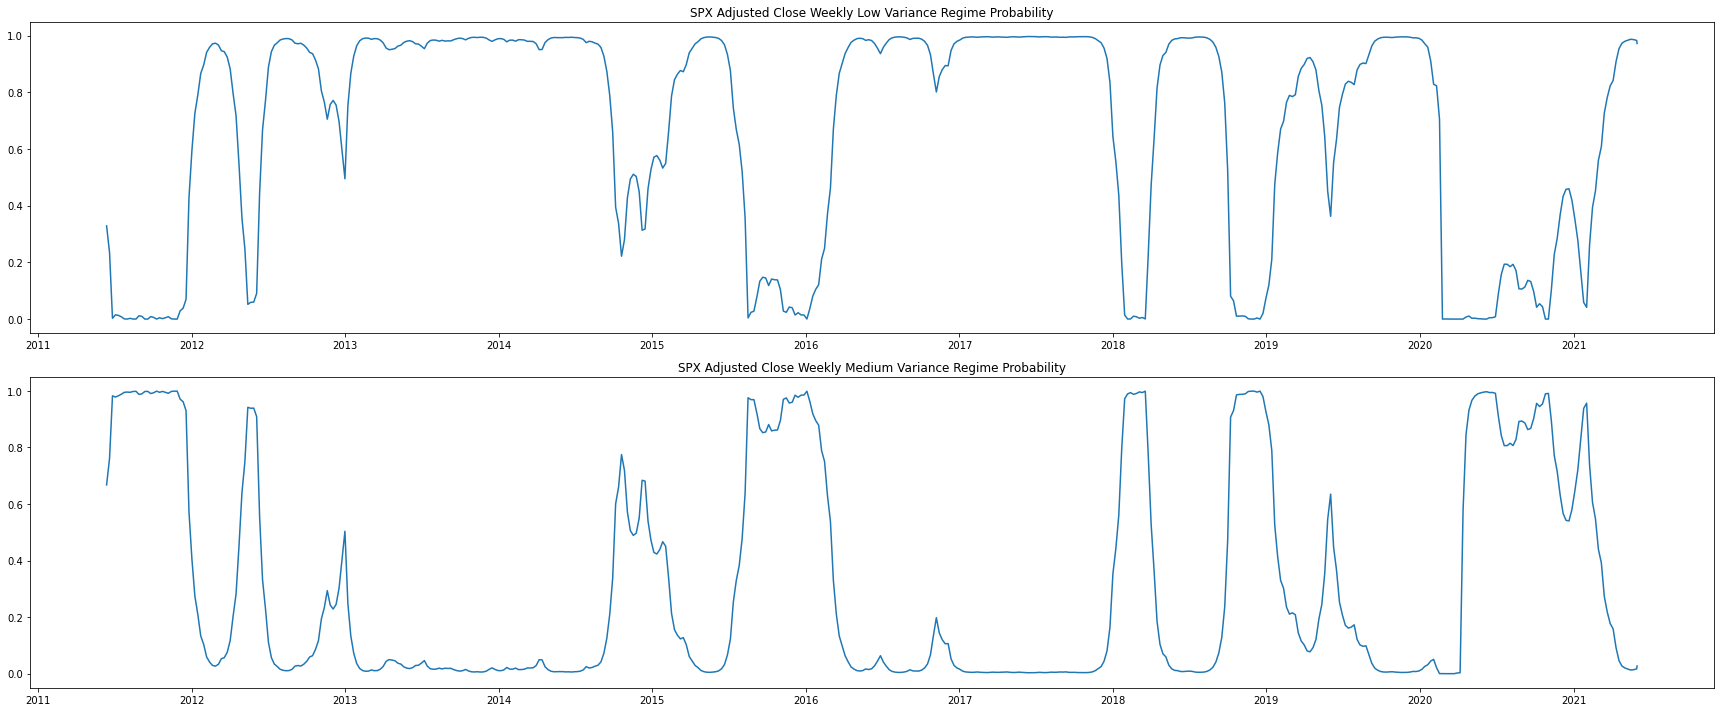

In [8]:
#now let's plot them to see how they will look
fig, axs = plt.subplots(nrows = 2, ncols =1, figsize = (24,10))

axs[0].plot(low_med['low_variance'])
axs[0].set_title("SPX Adjusted Close Weekly Low Variance Regime Probability")

axs[1].plot(low_med['medium_variance'])
axs[1].set_title("SPX Adjusted Close Weekly Medium Variance Regime Probability")

plt.tight_layout()
plt.show()

In [9]:
#now lets invert one of the time series in this case we'll flip low to fit with medium
regimes['inverted'] = 1 - regimes['low_variance']
regimes.head()

,low_variance,medium_variance,high_variance,inverted
Date,,,,
2011-06-13,0.328786,0.667559,0.003655,0.671214
2011-06-20,0.234574,0.761374,0.004052,0.765426
2011-06-27,0.002712,0.982479,0.014809,0.997288
2011-07-04,0.015028,0.978358,0.006614,0.984972
2011-07-11,0.013043,0.982640,0.004317,0.986957


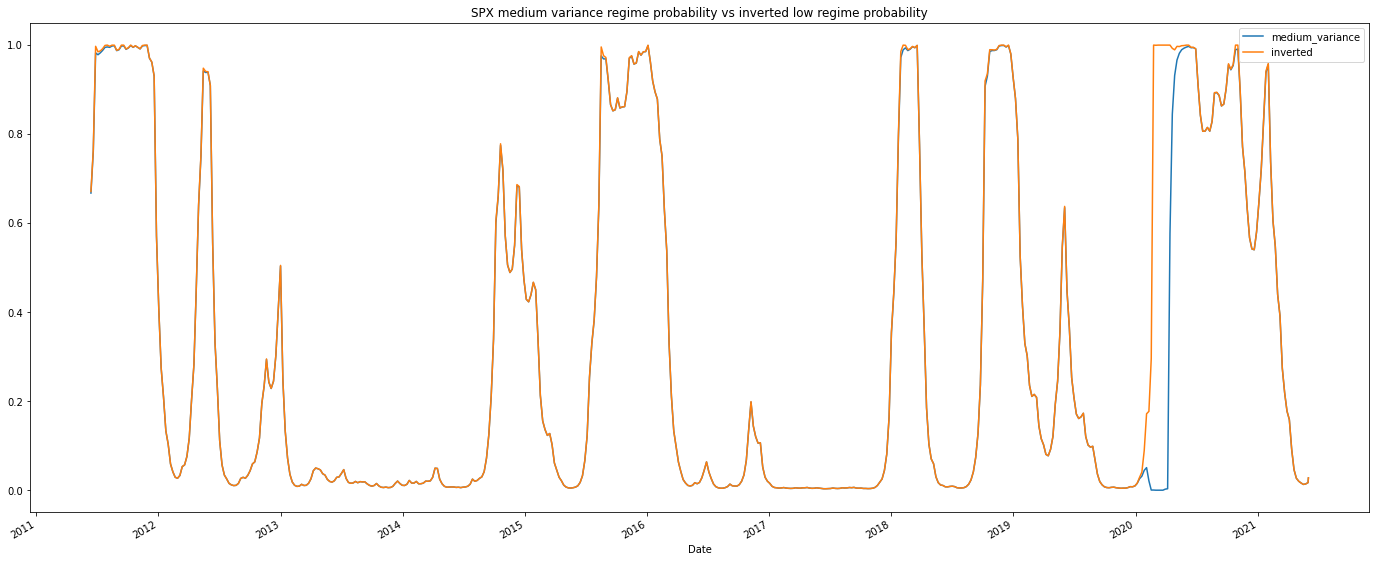

In [10]:
#now lets look at the inverted regime overlayed on the other one
regimes[['medium_variance', 'inverted']].plot(figsize = (24,10))
plt.title("SPX medium variance regime probability vs inverted low regime probability")
plt.show()

In [11]:
#now let's get the correlation which will create an indicator function
corr = regimes['medium_variance'].rolling(window = 2).corr(regimes['inverted'])
corr

Date
2011-06-13    NaN
2011-06-20    1.0
2011-06-27    1.0
2011-07-04    1.0
2011-07-11    1.0
             ... 
2021-05-10    1.0
2021-05-17    1.0
2021-05-24    1.0
2021-05-31    1.0
2021-06-01    1.0
Length: 522, dtype: float64

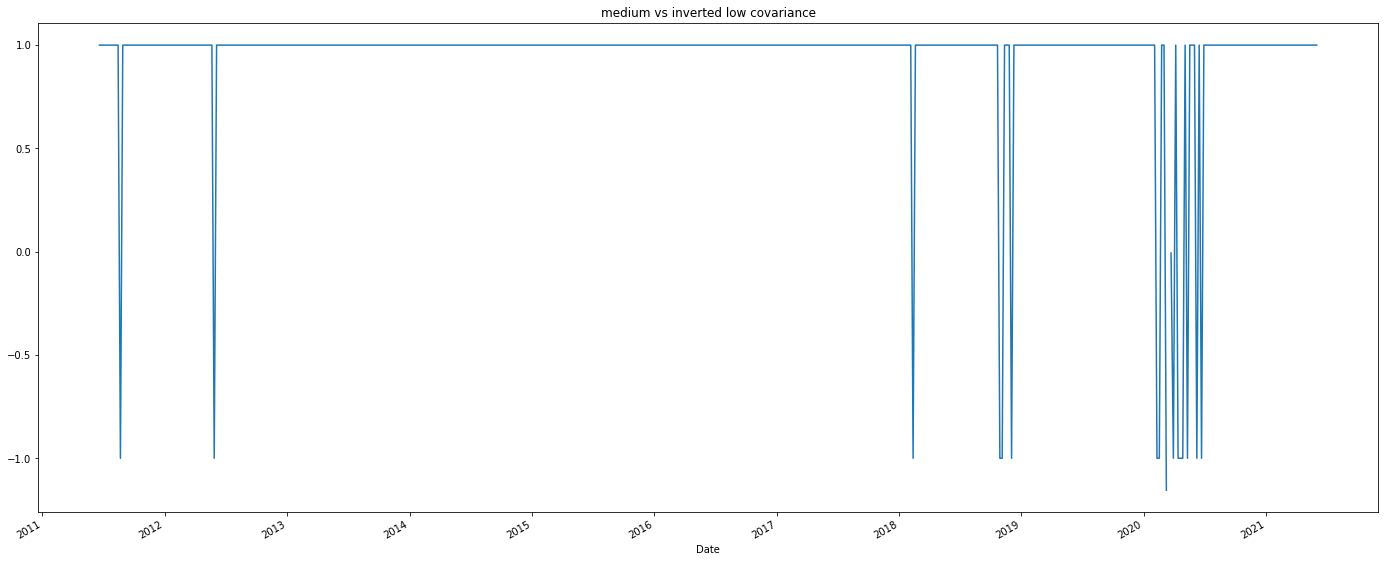

In [12]:
#lets look at the plot and you can see that we have made indicator functions
corr.plot(figsize = (24,10), title = "medium vs inverted low covariance")
plt.show()

In [13]:
print("df index:", df.index)
print(len(df.index))

df index: DatetimeIndex(['2011-05-30', '2011-06-06', '2011-06-13', '2011-06-20',
               '2011-06-27', '2011-07-04', '2011-07-11', '2011-07-18',
               '2011-07-25', '2011-08-01',
               ...
               '2021-04-05', '2021-04-12', '2021-04-19', '2021-04-26',
               '2021-05-03', '2021-05-10', '2021-05-17', '2021-05-24',
               '2021-05-31', '2021-06-01'],
              dtype='datetime64[ns]', name='Date', length=524, freq=None)
524


In [14]:
print("regimes index:", regimes.index)
print(len(regimes.index))

regimes index: DatetimeIndex(['2011-06-13', '2011-06-20', '2011-06-27', '2011-07-04',
               '2011-07-11', '2011-07-18', '2011-07-25', '2011-08-01',
               '2011-08-08', '2011-08-15',
               ...
               '2021-04-05', '2021-04-12', '2021-04-19', '2021-04-26',
               '2021-05-03', '2021-05-10', '2021-05-17', '2021-05-24',
               '2021-05-31', '2021-06-01'],
              dtype='datetime64[ns]', name='Date', length=522, freq=None)
522


In [15]:
#we have an index mismatch, honeslty don't know why but we'll chop off the extra 2 values in df so the indexes can match
df = df[2:]
df.head()

,Adj Close,return
Date,,
2011-06-13,1271.500000,0.000409
2011-06-20,1268.449951,-0.002399
2011-06-27,1339.670044,0.056147
2011-07-04,1343.800049,0.003083
2011-07-11,1316.140015,-0.020583


In [16]:
print("first:", df.index[0], "last:", df.index[len(df) - 1], "count:", len(df.index))

first: 2011-06-13 00:00:00 last: 2021-06-01 00:00:00 count: 522


In [17]:
print("first:", regimes.index[0], "last:", regimes.index[len(regimes) - 1], "count:", len(regimes.index))

first: 2011-06-13 00:00:00 last: 2021-06-01 00:00:00 count: 522


1123.530029296875 4232.60009765625


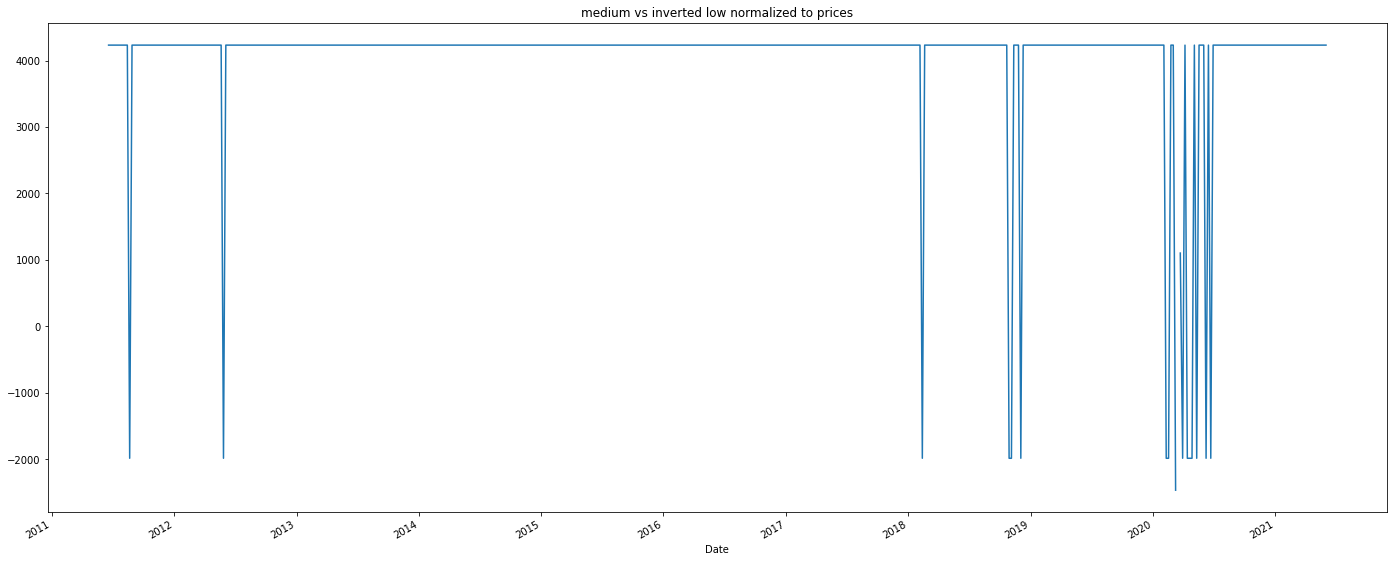

In [18]:
#now they are matched we can make the indexes work

#now we want to overlay the indicator function ovet the price to "show" filtering. Because we are treating this function
#as a indicator function we can normalize the values without worry of statistical mistkakes

#we need to get the lowest and highest value of the SPX prices
low, high = min(df['Adj Close']), max(df['Adj Close'])
print(low, high)

#now normalize the correlation between those values
corr_norm = pd.Series([low + (high - low) * x for x in corr])
corr_norm.index = df.index

#now let's plot that
corr_norm.plot(figsize = (24,10), title = "medium vs inverted low normalized to prices")
plt.show()

In [19]:
#now let's overlay the indicator-like function over the price let's put it all in one dataframe to be certain indexes match
plotting = pd.DataFrame()
plotting['prices'] = df['Adj Close']
plotting['indicator'] = corr_norm
plotting.head()

,prices,indicator
Date,,
2011-06-13,1271.500000,NaN
2011-06-20,1268.449951,4232.600098
2011-06-27,1339.670044,4232.600098
2011-07-04,1343.800049,4232.600098
2011-07-11,1316.140015,4232.600097


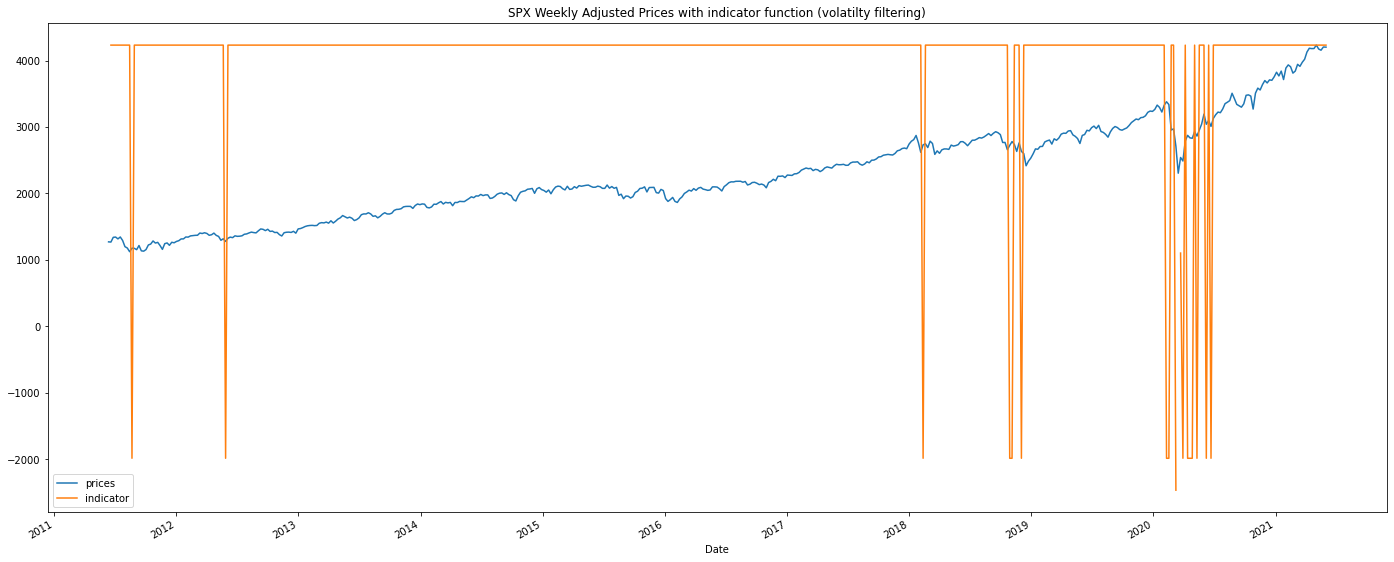

In [20]:
#now plot
plotting.plot(figsize = (24,10))
plt.title("SPX Weekly Adjusted Prices with indicator function (volatilty filtering)")
plt.show()